(mmm_budget_allocation_example)=
# Budget Allocation with PyMC-Marketing

The purpose of this notebook is to explore the recently included function in the PyMC-Marketing library that focuses on budget allocation. This function's underpinnings are based on the methodologies inspired by Bolt work in his article, ["Budgeting with Bayesian Models"](https://bolt.eu/en/blog/budgeting-with-bayesian-models-pymc-marketing/).

## Prerequisite Knowledge
The notebook assumes the reader has knowledge of the essential functionalities of PyMC-Marketing. If one is unfamiliar, the ["MMM Example Notebook"](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) serves as an excellent starting point, offering a comprehensive introduction to media mix models in this context.

## Context
The emphasis of this notebook is on enhancing marketing budgets. Contrarily to broader issues addressed in prior notebooks, our primary aim here is to unravel specialized knowledge on budget allocation tactics using the functionality.

## Objectives
To elucidate more efficient ways of resource allocation across diverse media channels.
To deliver data-driven, actionable insights for budgeting decisions.

## Introducing the budget allocator
This notebook instigates an examination of the function within the PyMC-Marketing library, which addresses these challenges using Bayesian models. The function intends to provide:

1. Quantitative measures of the effectiveness of different media channels.
2. Probabilistic ROI estimates under a range of budget scenarios.

## What to Anticipate
Upon completing this notebook, readers should get a comprehensive understanding of the budget allocation function. They will then be equipped to incorporate this analytic tool into their marketing analytics routines for data-driven decision-making.

## Installing PyMC-Marketing
Before delving into the specifics of budget allocation, the initial step is to install the PyMC-Marketing library and ascertain its version. This step will confirm support for the budget allocation function. The following pip command can be run on your Jupyter Notebook:

## Basic Setup
Like previous notebooks revolving around PyMC-Marketing, this relies on a specific library set. Here are the requisite imports necessary for executing the provided code snippets subsequently.

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

These imports and configurations form the fundamental setup necessary for the entire span of this notebook.

The expectation is that a model has already been trained using the functionalities provided in prior versions of the PyMC-Marketing library. Thus, the data generation and training processes will be replicated in a different notebook. Those unfamiliar with these procedures are advised to refer to the ["MMM Example Notebook."](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

### Employing ModelBuilder: A Feature in PyMC-Marketing
The ModelBuilder feature, introduced in version 0.2.0 of PyMC-Marketing, empowers users to easily save and load pre-trained models. The capability to load a pre-existing model is especially advantageous for accelerating analyses, mainly when dealing with expansive data sets or intricate models.

### Saving Model
Once the model has been trained, it is easy to save for later use. An example of the ".save" method is demonstrated below to store the model at a designated [location](https://github.com/pymc-labs/pymc-marketing/tree/main/data).

## Loading a Pre-Trained Model
To utilize a saved model, load it into a new instance of the DelayedSaturatedMMM class using the load method below.

In [2]:
name = "/Users/carlostrujillo/Documents/GitHub/pymc-marketing/data/model.nc"
mmm = DelayedSaturatedMMM.load(name)

For more details on the `save()` and `load()` methods, consult the [pymc-marketing documentation](https://www.pymc-marketing.io/en/stable/guide/benefits/model_deployment.html) on Model Deployment.

## Problem Statement
Before jumping into the data, let’s first define the business problem we are trying to solve.In a progressively competitive scenario, marketers are tasked with distributing a predetermined marketing budget across various channels for optimizing Return on Investment (ROI). Consider a forthcoming quarter wherein a marketing team must decide the division of its operations between two advertising channels, represented as x1 and x2. These could effectively symbolize any medium, such as TV, digital advertising, print, etc.

The task lies in making decisions that invoke data, comply with factual evidence, and align with business logic. For instance, how can one incorporate prior information like budget restrictions, platform trends, constraints, or even distinctive features of each channel into the decision-making process?

## Introducing Budget Allocation Function
The updated budget allocation function in PyMC-Marketing aims to tackle this issue by offering a Bayesian framework for optimal allocation. This enables marketers to:

* Integrate the outcomes of Media Mix Modeling (MMM), quantifying each channel's effectiveness in metrics like ROI, incremental sales, etc.
* Merge this empirical data with prior business knowledge and logic for making holistic and robust decisions.

By utilizing this function, marketers can guarantee that the budget spread not only obeys the mathematical rigor furnished by the MMM outcomes but also incorporates business-specific factors, thereby achieving a balanced and optimized budget plan.

## Getting started
Media Mix Modeling (MMM) acts as a dependable method to estimate the contribution of each channel (e.g., x1, x2) to a target variable like sales or any variable. The function `plot_direct_contribution_curves()` allows for visualization of this direct channel impact. However, it is crucial to remember that this only unveils the "observable space" for values of X (spend) and Y (contribution).

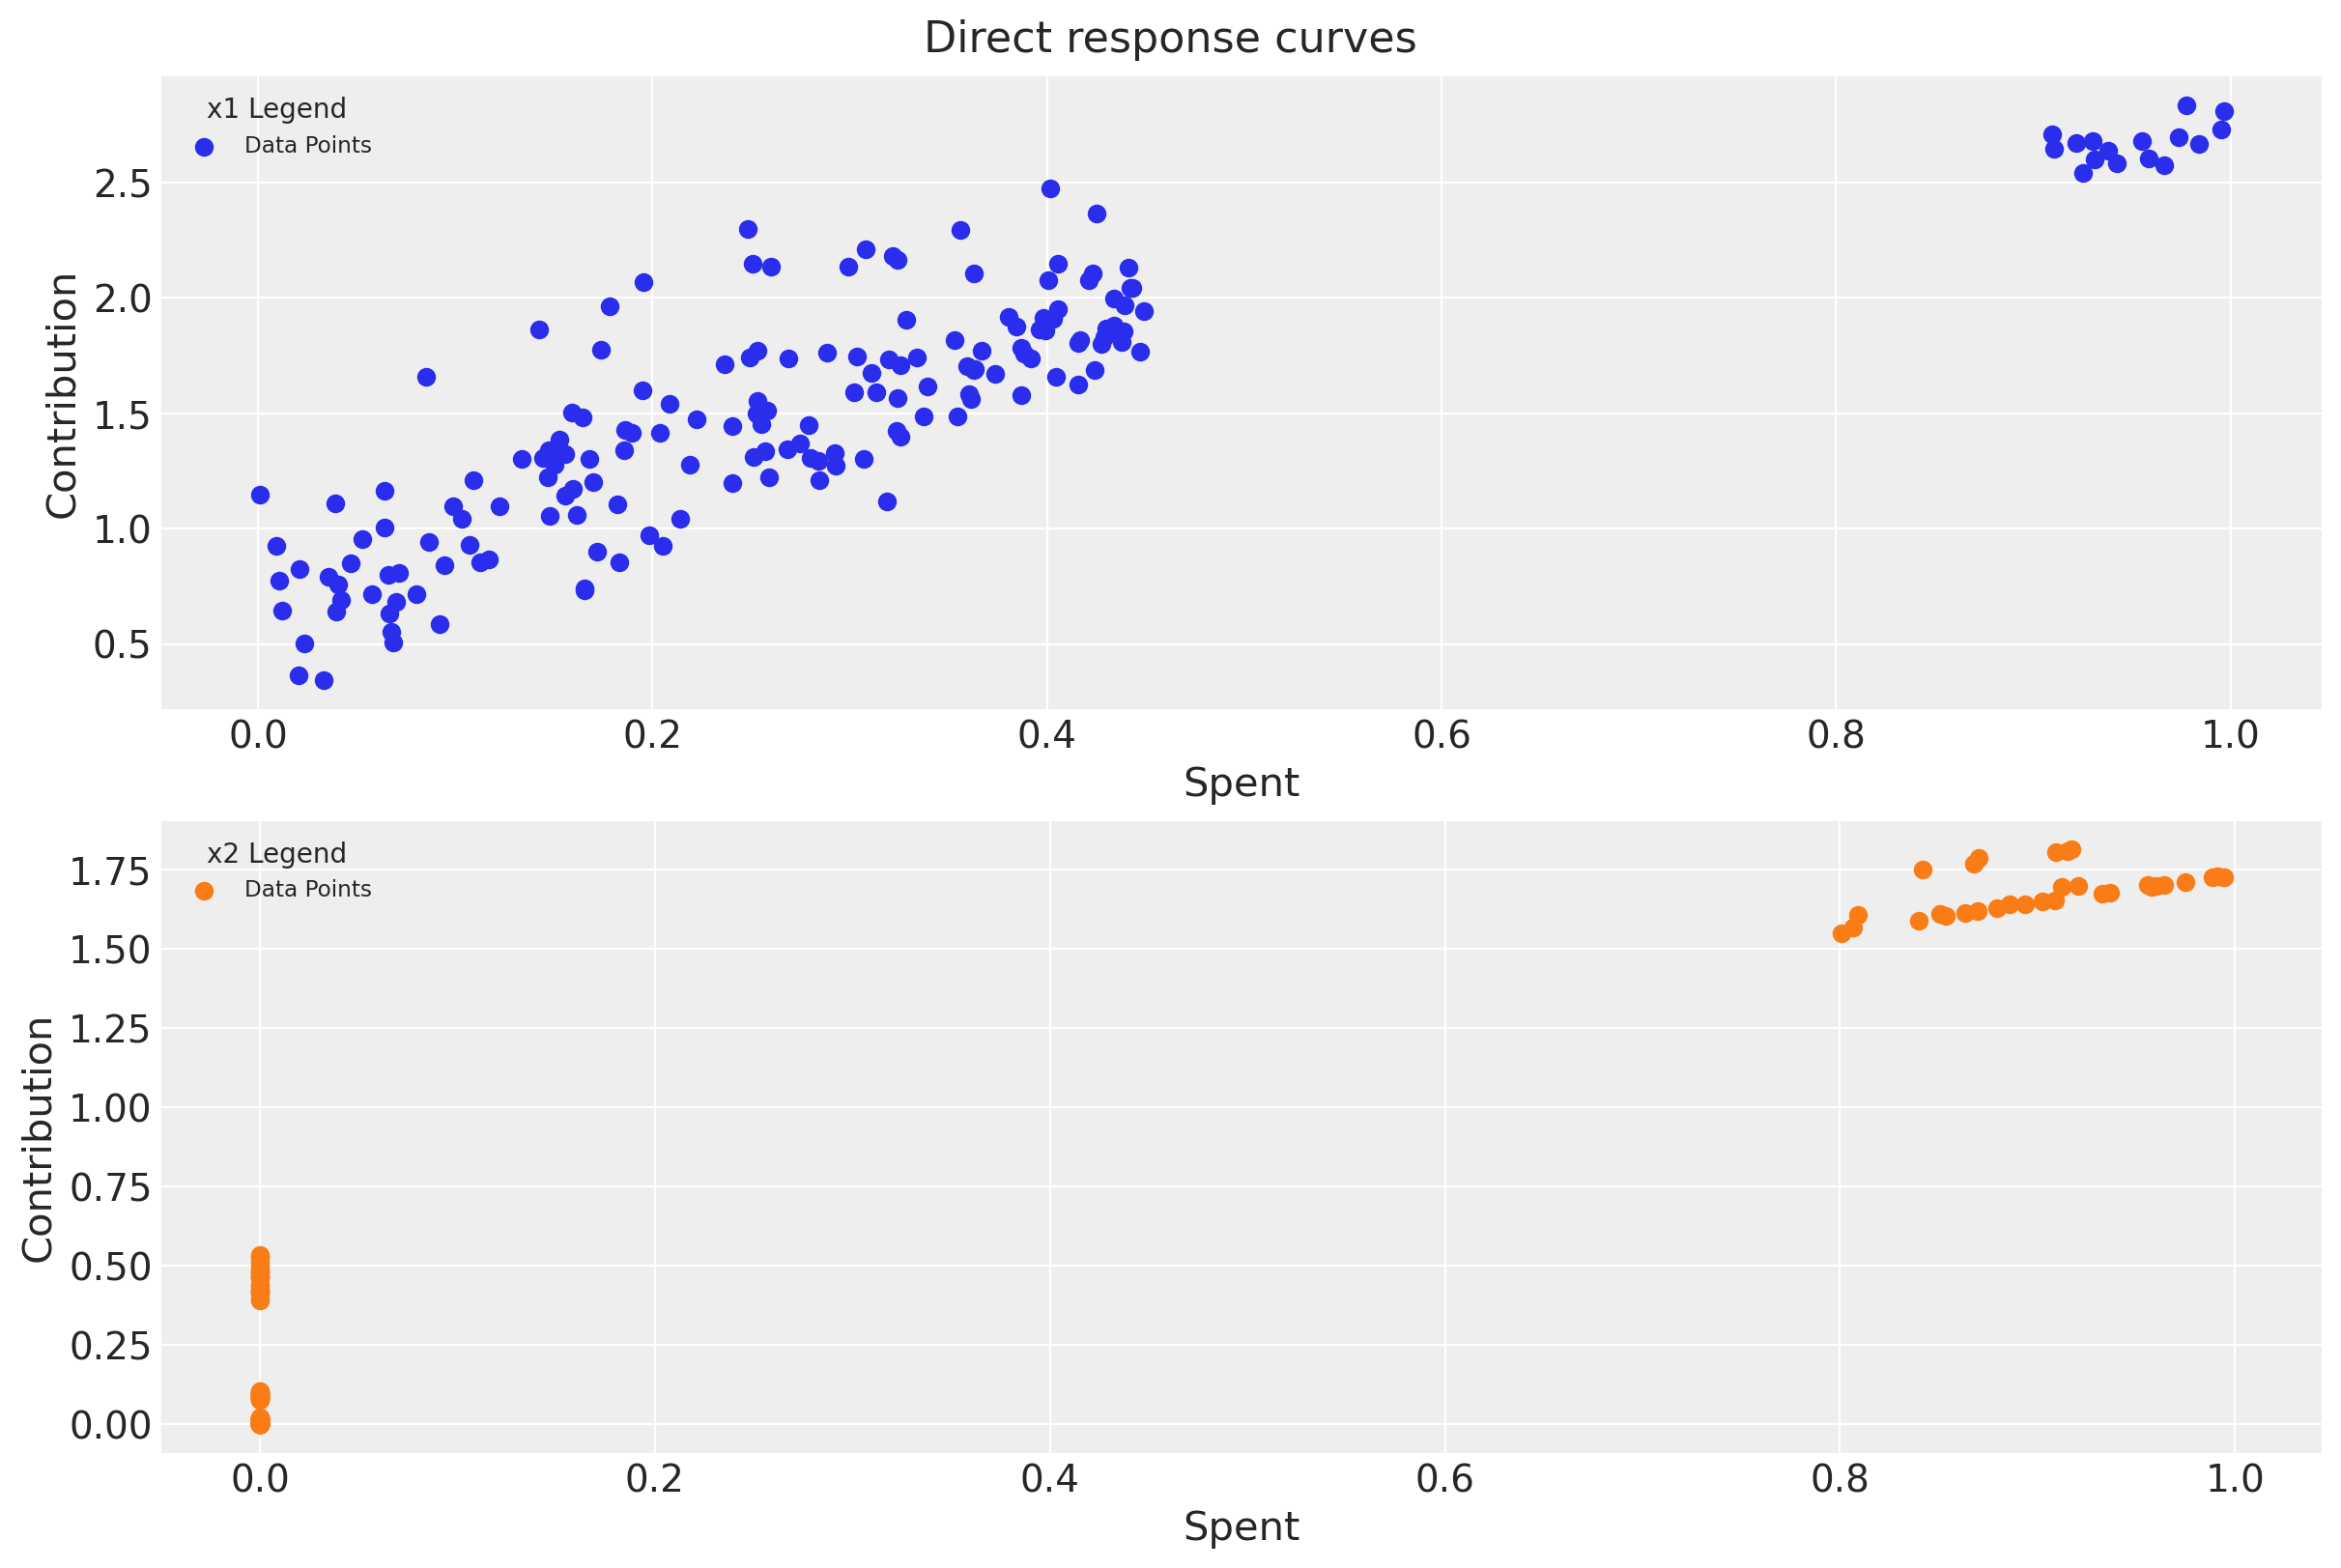

In [3]:
response_curve_fig = mmm.plot_direct_contribution_curves();

The observable space only encompasses our data points and does not illustrate what transpires beyond those points. As a result, it is not assured that the maximum contribution point for each channel lies within this observable range.

By using the `xlim_max` parameter, we can predict the shape of the model fitting curve for the amount spent that was not previously observed.

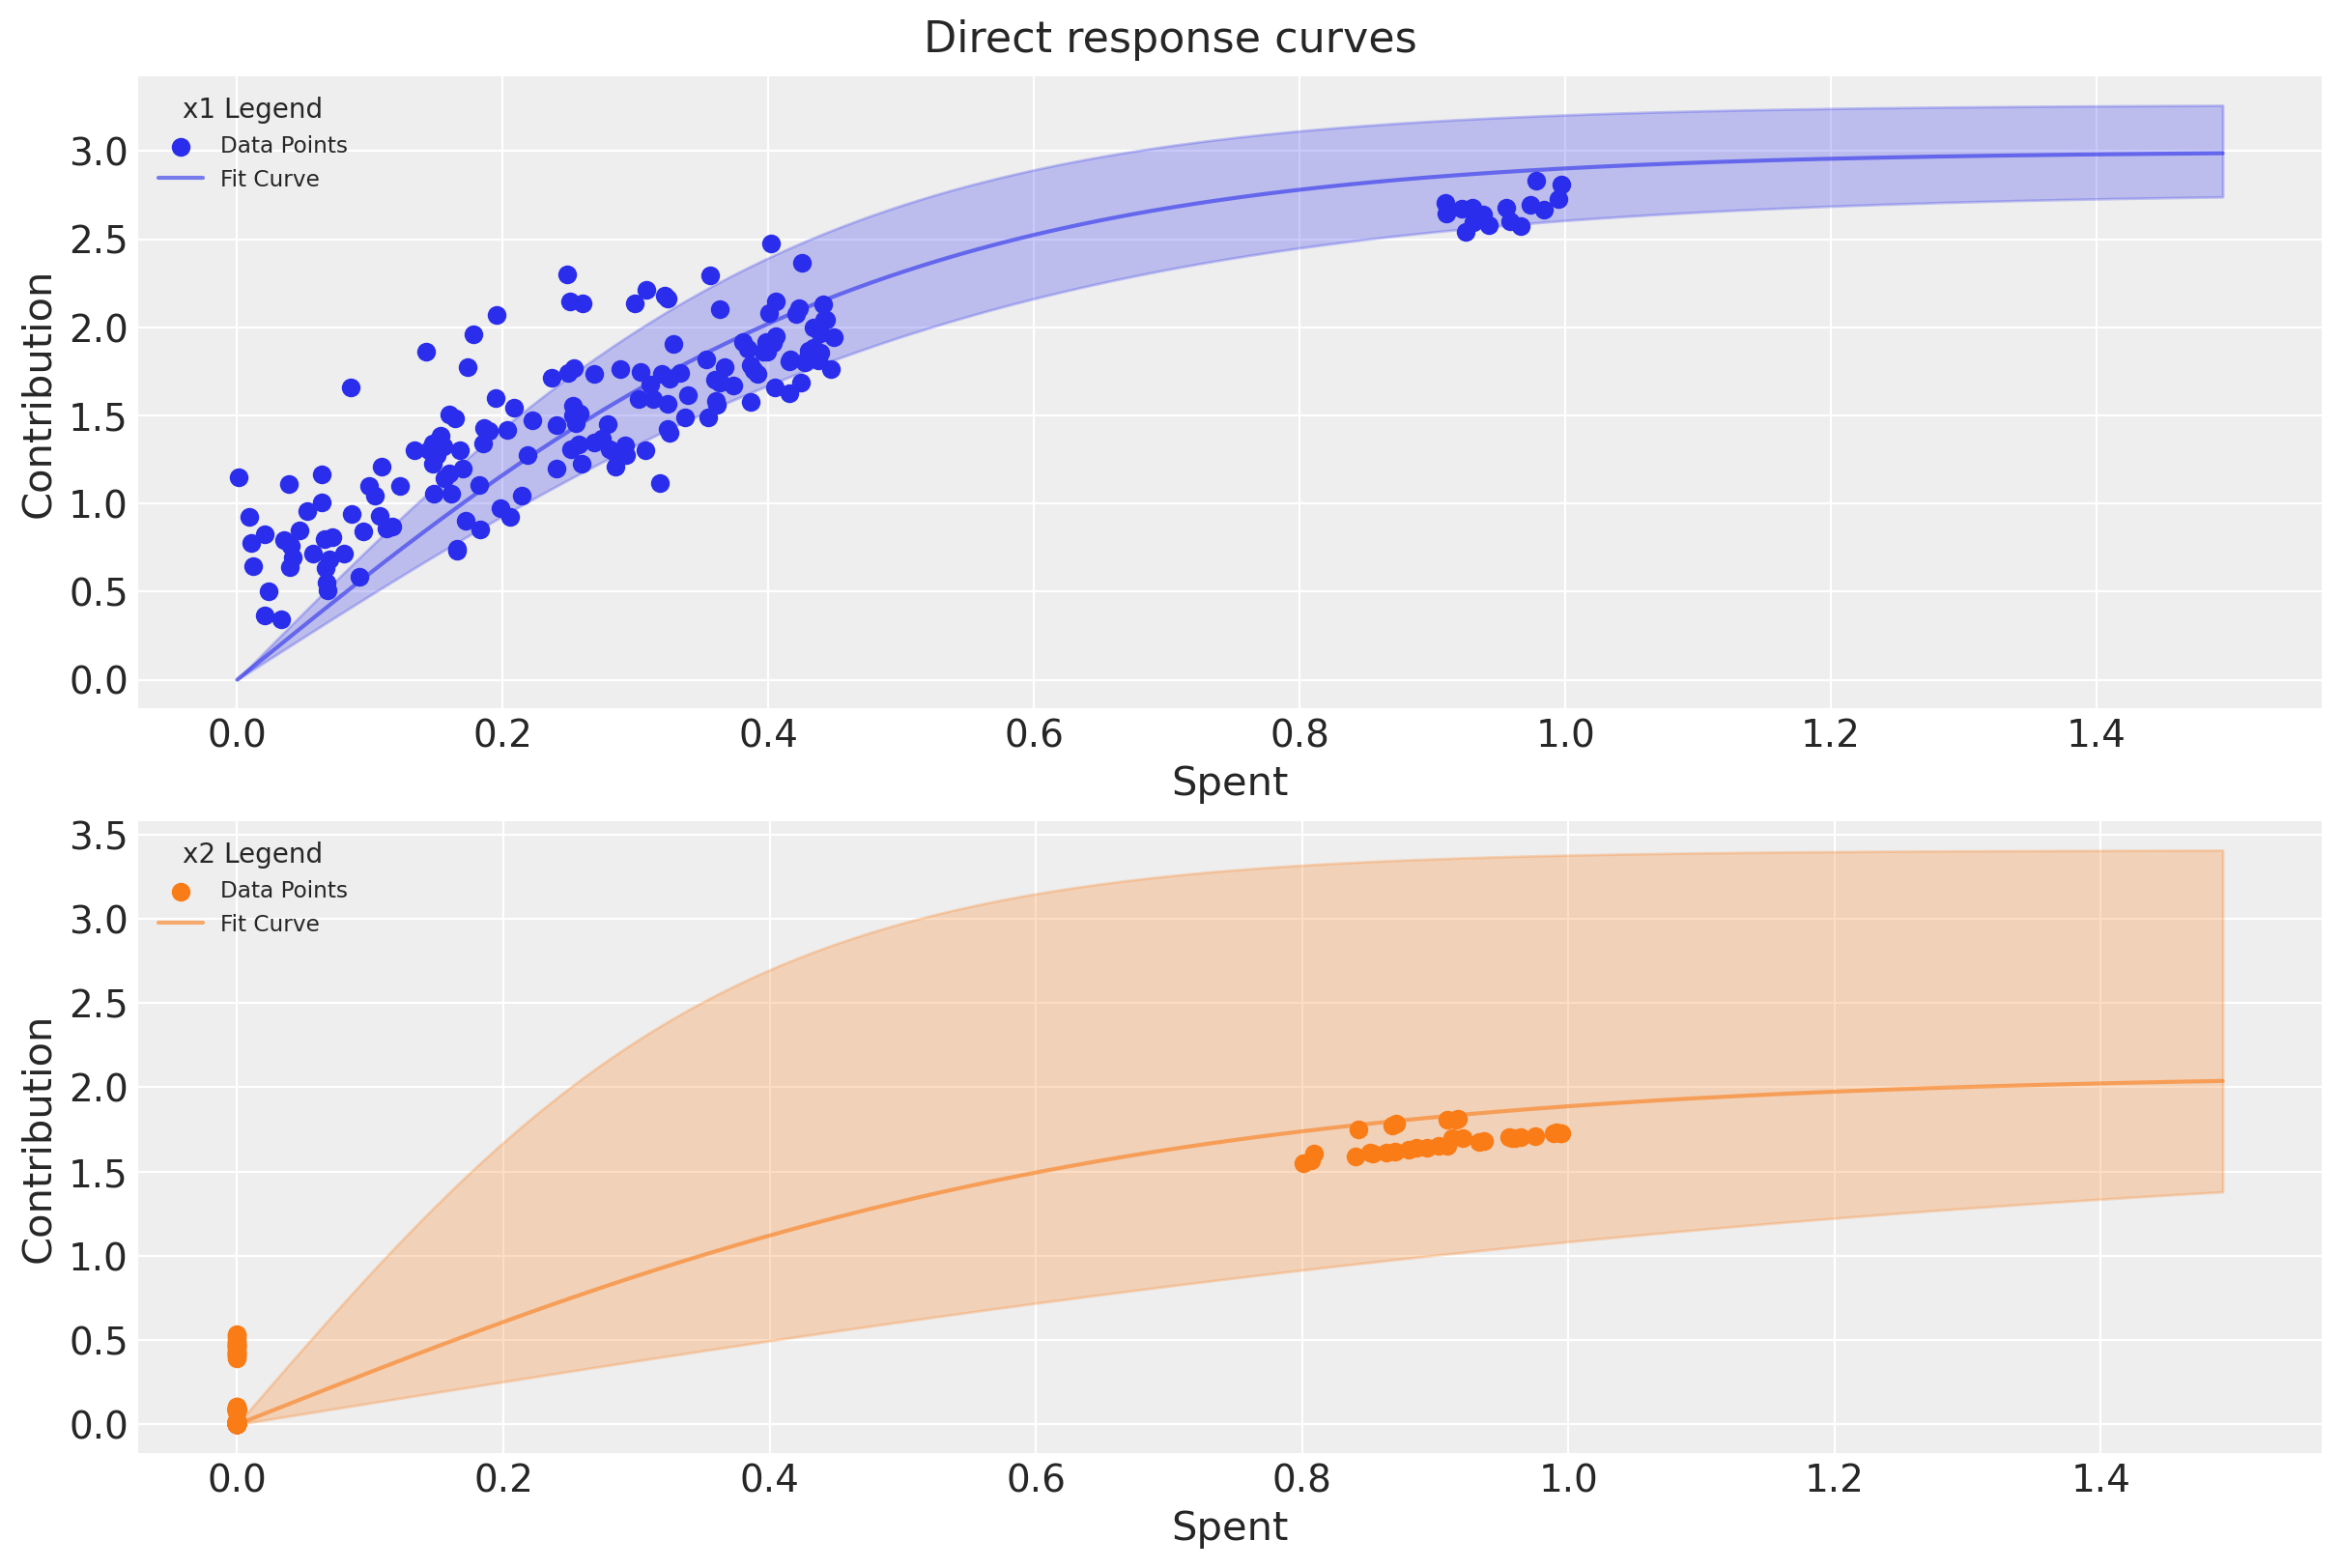

In [4]:
mmm.plot_direct_contribution_curves(
    show_fit=True,
    xlim_max=1.5
);

The fit of the model comes from the saturation function selected at the time of training. You can verify this by directly accessing the model method and plotting the class name.

In [5]:
print(
    f"Model was train using the {mmm.saturation.__class__.__name__} function"
)
print(
    f"and the {mmm.adstock.__class__.__name__} function"
)

Model was train using the LogisticSaturation function
and the GeometricAdstock function


Within PyMC-Marketing we have different saturation functions, you can observe all in the [transformer module](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.mmm.transformers.html).

Let's understand a few saturation functions with a few examples!

## Understanding Saturation Functions: Sigmoid and Michaelis-Menten
What do we mean by saturation functions? We assume the effect of spend on sales is not linear and saturates at some point. Two prevalent functions deployed to comprehend and estimate the saturation effects in advertising channels are the sigmoid and the Michaelis-Menten functions.

### Sigmoid Function
The sigmoid function is formulated as:
$$
\beta \cdot \frac{\exp(-\lambda x)}{1 + \exp(-\lambda x)}
$$
Key Elements:
* β (beta): Denotes the Asymptotic Maximum or Ceiling Value. It is the point that the function approaches as the input x becomes immense.
* λ (Lambda): Influences the steepness of the curve. A more substantial value of λ renders the curve steeper, while a lesser value makes it more even-paced.

### Michaelis-Menten Function
The Michaelis-Menten function is formulated as:
$$
\frac{\alpha \times x}{\lambda + x}
$$

Key Elements:
* α (Alpha or Vmax): It represents the maximum contribution (y) a channel can make, also recognized as the plateau point.
* λ (k): Denotes the elbow on the function in x, signifying the moment when the curve adjusts its direction.

## Which Function to Use?
The preference between the sigmoid and Michaelis-Menten functions ought to be steered by the data's goodness of fit. But it really comes down to your assumptions about where the peak might be and the speed at which it saturates the curve.

> **Tip**: When you're choosing a saturation function, it's helpful to consider the data you already have. While saturation functions may have different parameterizations, they all have the same effect. If you already know about any relationship between spending and response, it's a good idea to pick a function with the same parameter values. This will help you understand and analyze its operation and outcomes better, which is essential within the Bayesian framework.

Once these parameters are obtained, you can visualize it using the `arviz.summary` function (each parameter has the prefix `saturation` or `adstock` respectively) and, if desired, you can recreate the curves for each channel independently based on them. More crucially, these parameter values are indispensable when using the `budget_allocator` function, which leverages this information to optimize your marketing budget across distinct channels. This section is fundamental to budget optimization.

In [6]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
saturation_beta[x1],0.362,0.018,0.330,0.399,0.000,0.000,2078.0,2088.0,1.0
saturation_beta[x2],0.276,0.114,0.192,0.395,0.004,0.003,1388.0,1060.0,1.0
saturation_lam[x1],4.067,0.360,3.371,4.727,0.007,0.005,2385.0,2087.0,1.0
saturation_lam[x2],3.130,1.182,1.022,5.408,0.030,0.021,1434.0,1044.0,1.0
adstock_alpha[x1],0.397,0.030,0.340,0.452,0.001,0.000,2601.0,2419.0,1.0
adstock_alpha[x2],0.193,0.040,0.118,0.268,0.001,0.001,2106.0,2210.0,1.0


## Example Use-Cases
The `budget_allocator` function within PyMC-Marketing boasts a myriad of applications that can solve various business predicaments. Here, we present five critical use cases that exemplify its utility in real-world marketing scenarios.

### What are we optimizing?
Before jumping into the examples, we need to understand the basis of our optimizer.

We aim to optimize the allocation of budgets across multiple channels to maximize the overall contribution to key performance indicators (KPIs), such as sales or conversions. Each channel has its own sigmoid or michaelis-menten curve, representing the relationship between the amount spent and the resultant performance.

These curves vary in characteristics: some channels saturate quickly, meaning that additional spending yields diminishing returns, while others may offer more linear growth in contribution with increased spending.

To solve this optimization problem, we employ the Sequential Least Squares Quadratic Programming ([SLSQP](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp)) algorithm, a gradient-based optimization technique. SLSQP is well-suited for this application as it allows for the imposition of both equality and inequality constraints, ensuring that the budget allocation adheres to business rules or limitations.

The algorithm works by iteratively approximating the objective function and constraints using quadratic functions and solving the resulting sub-problems to find a local minimum. This enables us to effectively navigate the multidimensional space of budget allocations to find the most efficient distribution of resources.

The optimizer aims to maximize the total contribution from all channels while adhering to the following constraints:

1. Budget Limitations: The total spending across all channels should not exceed the overall marketing budget.
2. Channel-specific Constraints: Some channels may have minimum or maximum spending limits.

By leveraging the SLSQP algorithm, we can optimize the multi-channel budget allocation in a rigorous, mathematically sound manner, ensuring that we get the highest possible return on investment.

### Maximizing Contribution
Assume you're managing the marketing for a retail company with a substantial budget to allocate for advertising across multiple channels. Suppose you're already apportioning funds to channels x1 and x2. Still, you're contemplating ways to optimize the forthcoming quarter's outlay to maximize the overall contribution.

Without, you might have considered scattering your money linearly without an MMM model - equal investments in each channel. However, you wish to explore better alternatives now that you possess an MMM model. Given that you lack prior knowledge, you impose the same restrictions on both channels. They must each expend a minimum of 1 million euros and no more than 5 million, equating to your total budget.

In [7]:
total_budget = 5  # Imagine is 5K or 5M
# Define your channels
channels = ["x1", "x2"]
# The initial split per channel
budget_per_channel = total_budget / len(channels)
# Initial budget per channel as dictionary.
initial_budget_dict = {channel: budget_per_channel for channel in channels}
# bounds for each channel
min_budget, max_budget = 1, 5
budget_bounds = {channel: [min_budget, max_budget] for channel in channels}

We can use our function and see the results with this information saved.

In [8]:
response = mmm.allocate_budget_to_maximize_response(
    budget=total_budget,
    num_days=8,
    time_granularity="weekly",
    budget_bounds=budget_bounds
)

Sampling: [y]


In [9]:
print(mmm.optimal_allocation_dict)

{'x1': 3.127614481306823, 'x2': 1.889150901128729}


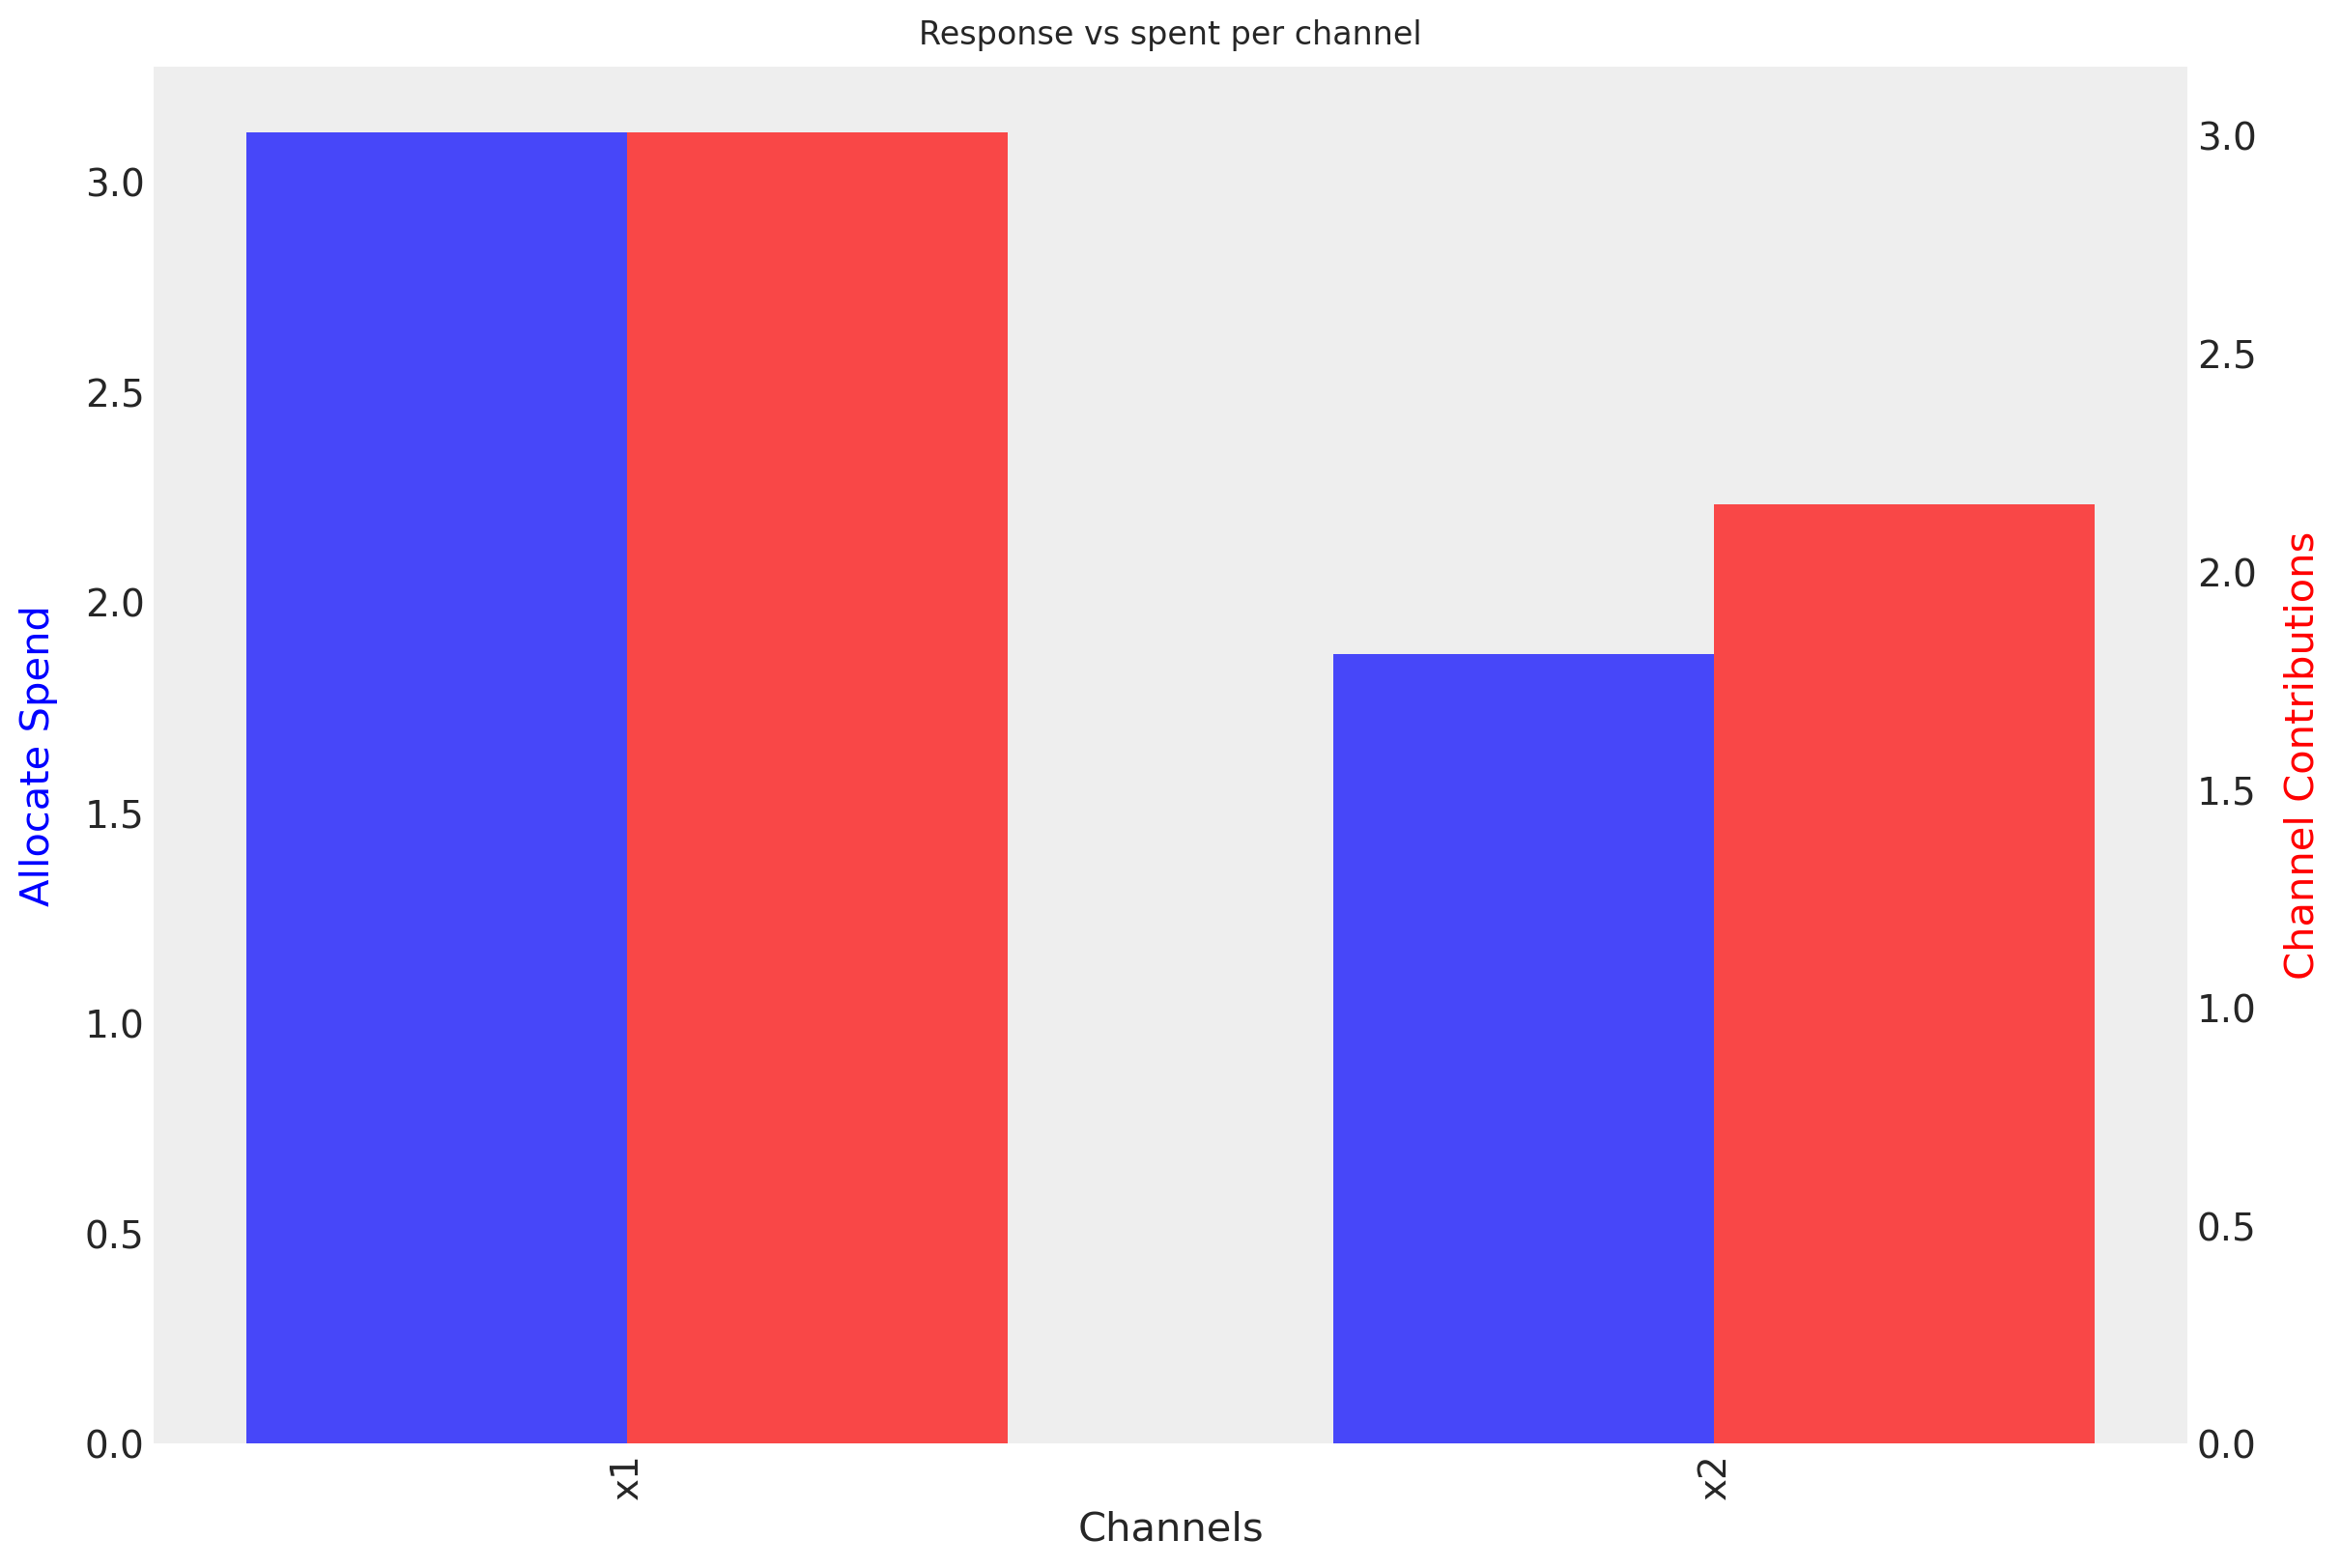

In [10]:
fig, ax = mmm.plot_budget_allocation(samples=response, figsize=(12, 8))
fig.suptitle("Response vs spent per channel");

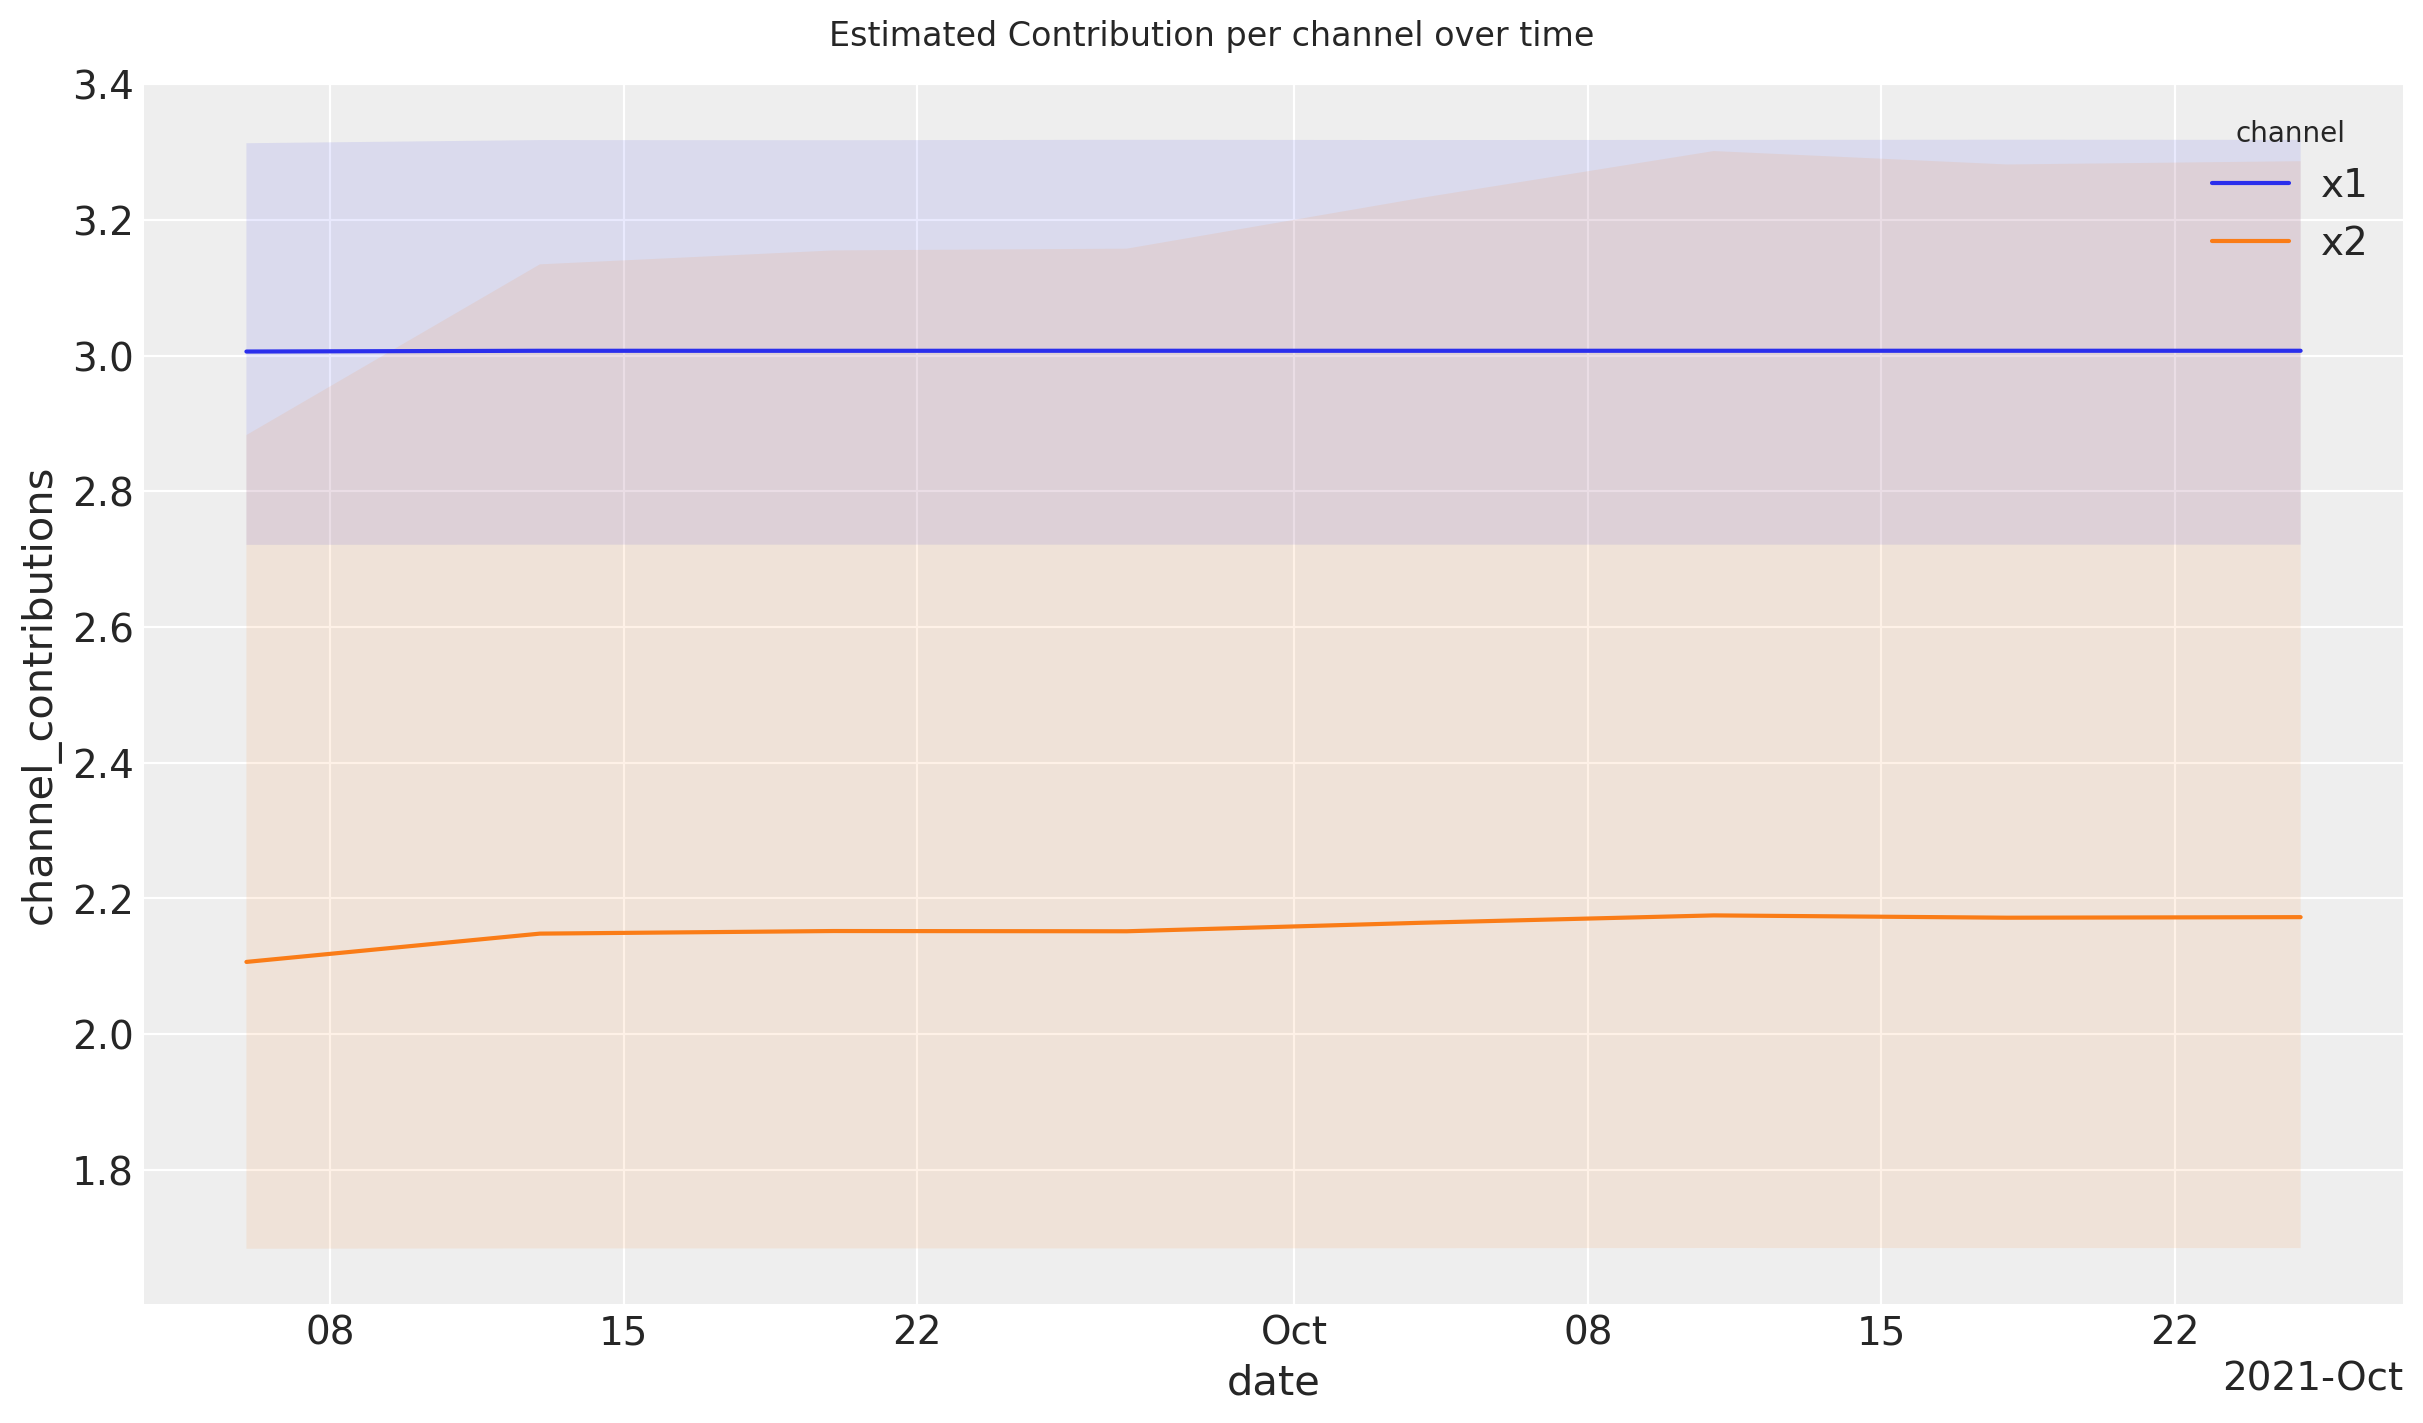

In [11]:
fig = mmm.plot_allocated_contribution_by_channel(samples=response)
fig.suptitle("Estimated Contribution per channel over time");

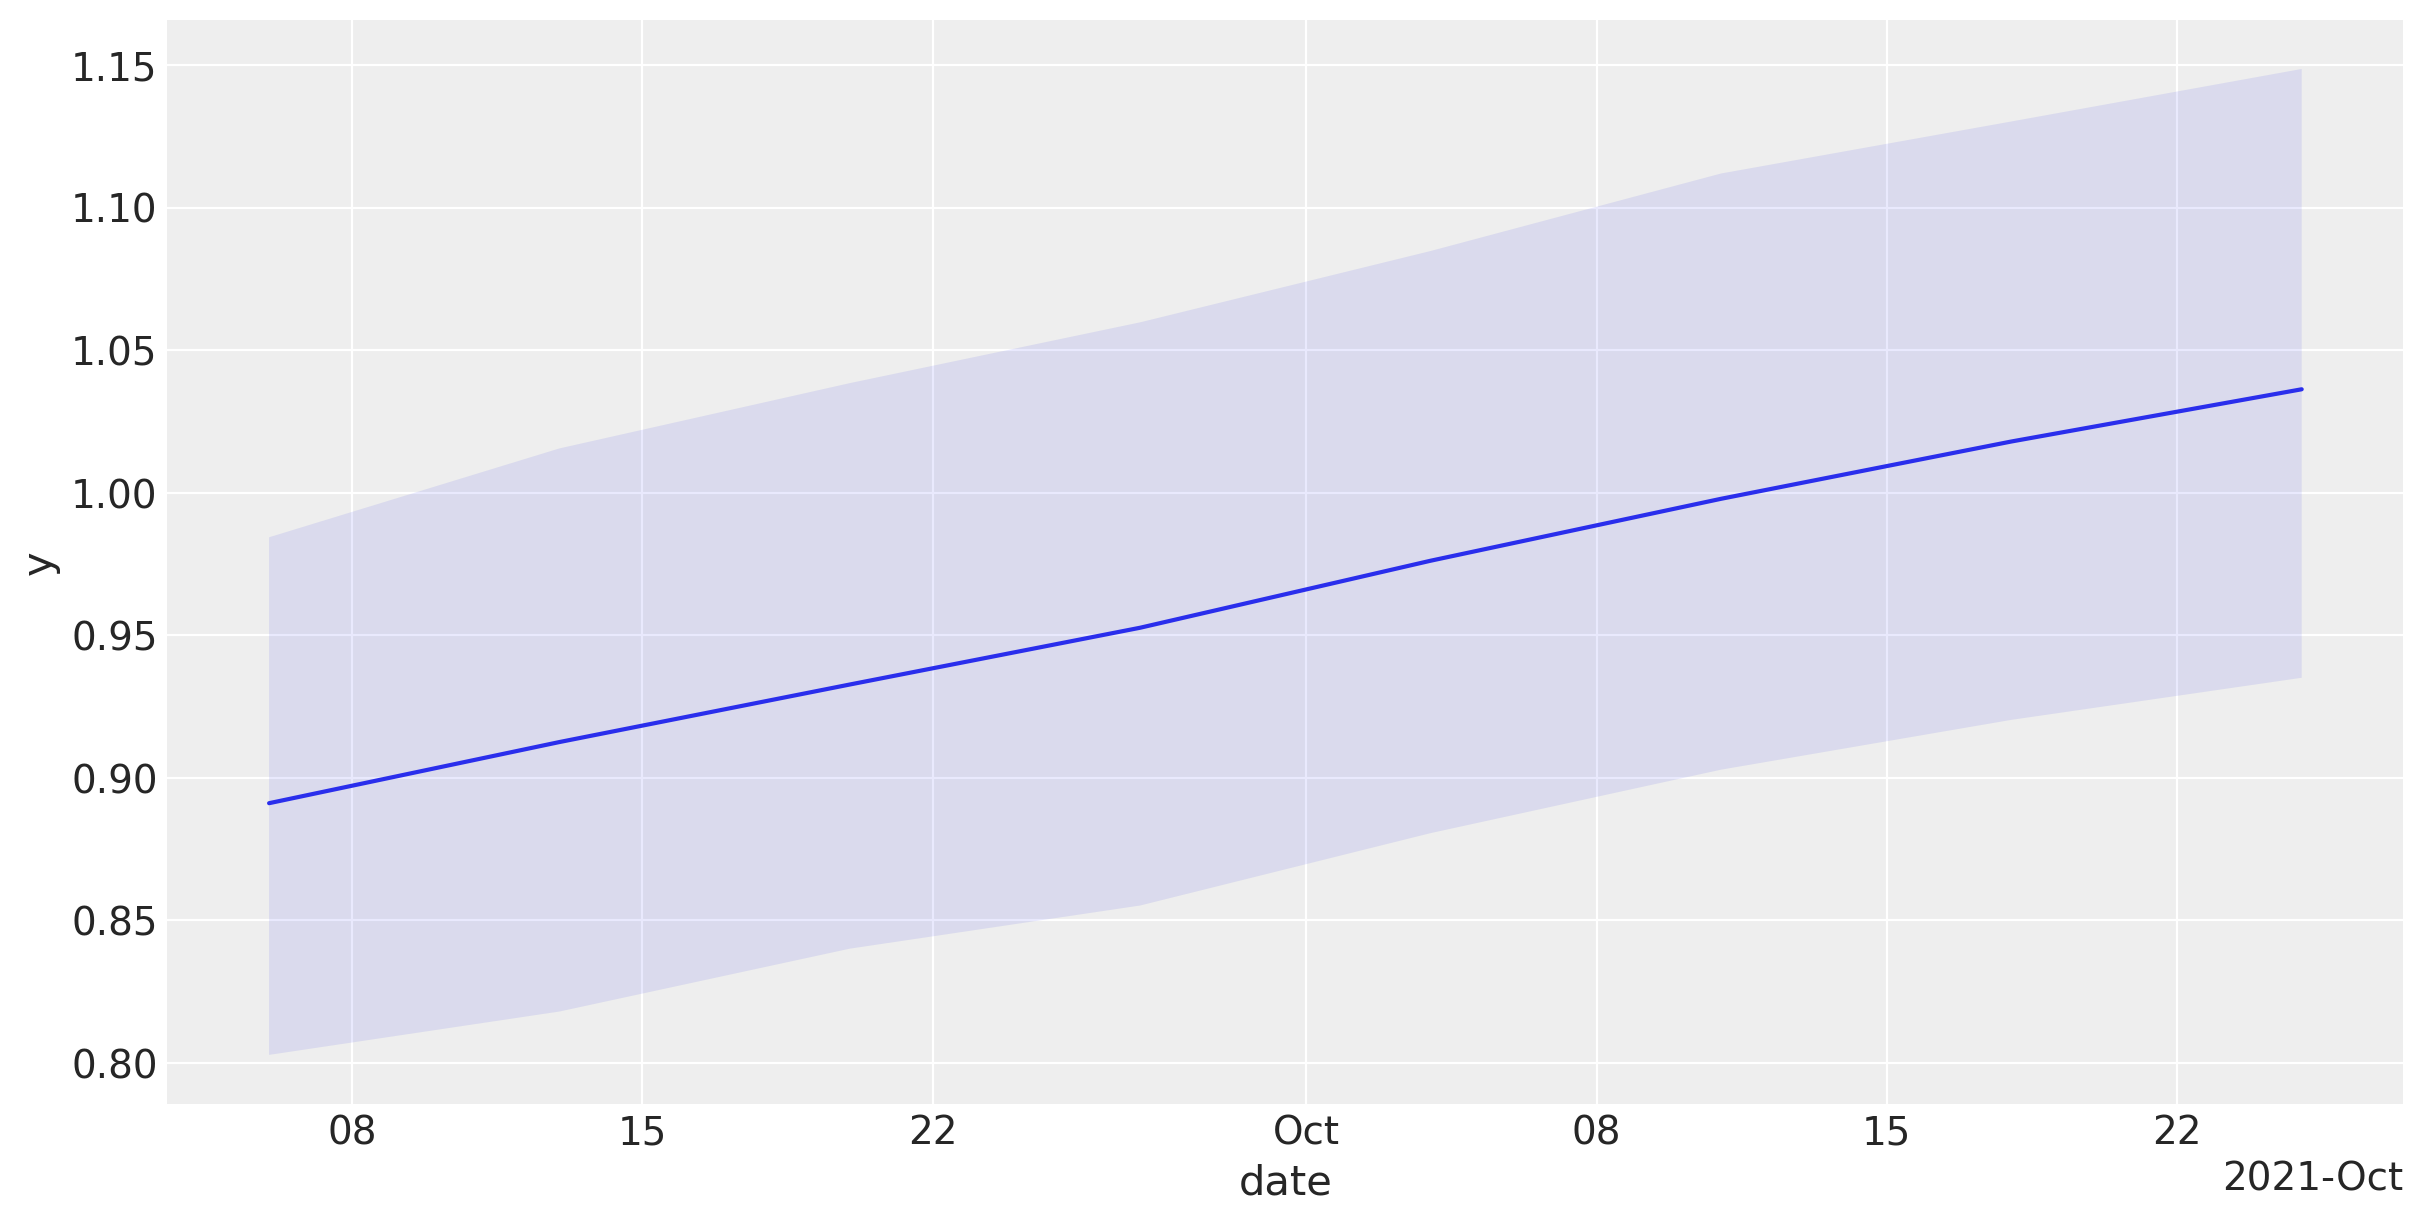

In [12]:
plt.figure(figsize=(12, 6))
plt.title("Optimal total marketing contribution")
response["y"].mean(dim="sample").plot()
plt.fill_between(
    x=response.y.date.values,
    y1=response.y.quantile(.025, dim="sample"),
    y2=response.y.quantile(.95, dim="sample"),
    alpha=.1,
);

These results are expected based on the estimates from the curve and our estimated average contribution from the posterior distribution.

However, based on our main assumptions, how can we ensure this result is optimal? How can we compare this outcome to what we would initially have if we followed our first setup?

In [13]:
last_date = mmm.X["date_week"].max()

# New dates starting from last in dataset
n_new = 8
new_dates = pd.date_range(start=last_date, periods=1 + n_new, freq="W-MON")[1:]

initial_budget_scenario = pd.DataFrame(
    {
        "date_week": new_dates,
    }
)

# Same channel spends as last day
initial_budget_scenario["x1"] = initial_budget_dict["x1"]
initial_budget_scenario["x2"] = initial_budget_dict["x2"]

# Other features
initial_budget_scenario["event_1"] = 0
initial_budget_scenario["event_2"] = 0

initial_budget_scenario["t"] = 0

response_initial_budget = mmm.sample_posterior_predictive(
    X_pred=initial_budget_scenario, extend_idata=False
)

response_initial_budget

Sampling: [y]


Output()

<xarray.Dataset> Size: 352kB
Dimensions:  (date: 8, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 64B 2021-09-06 2021-09-13 ... 2021-10-25
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 256kB 7.272 6.898 7.539 ... 7.84 8.486 8.461
Attributes:
    created_at:                 2024-06-03T20:49:57.676747+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.0

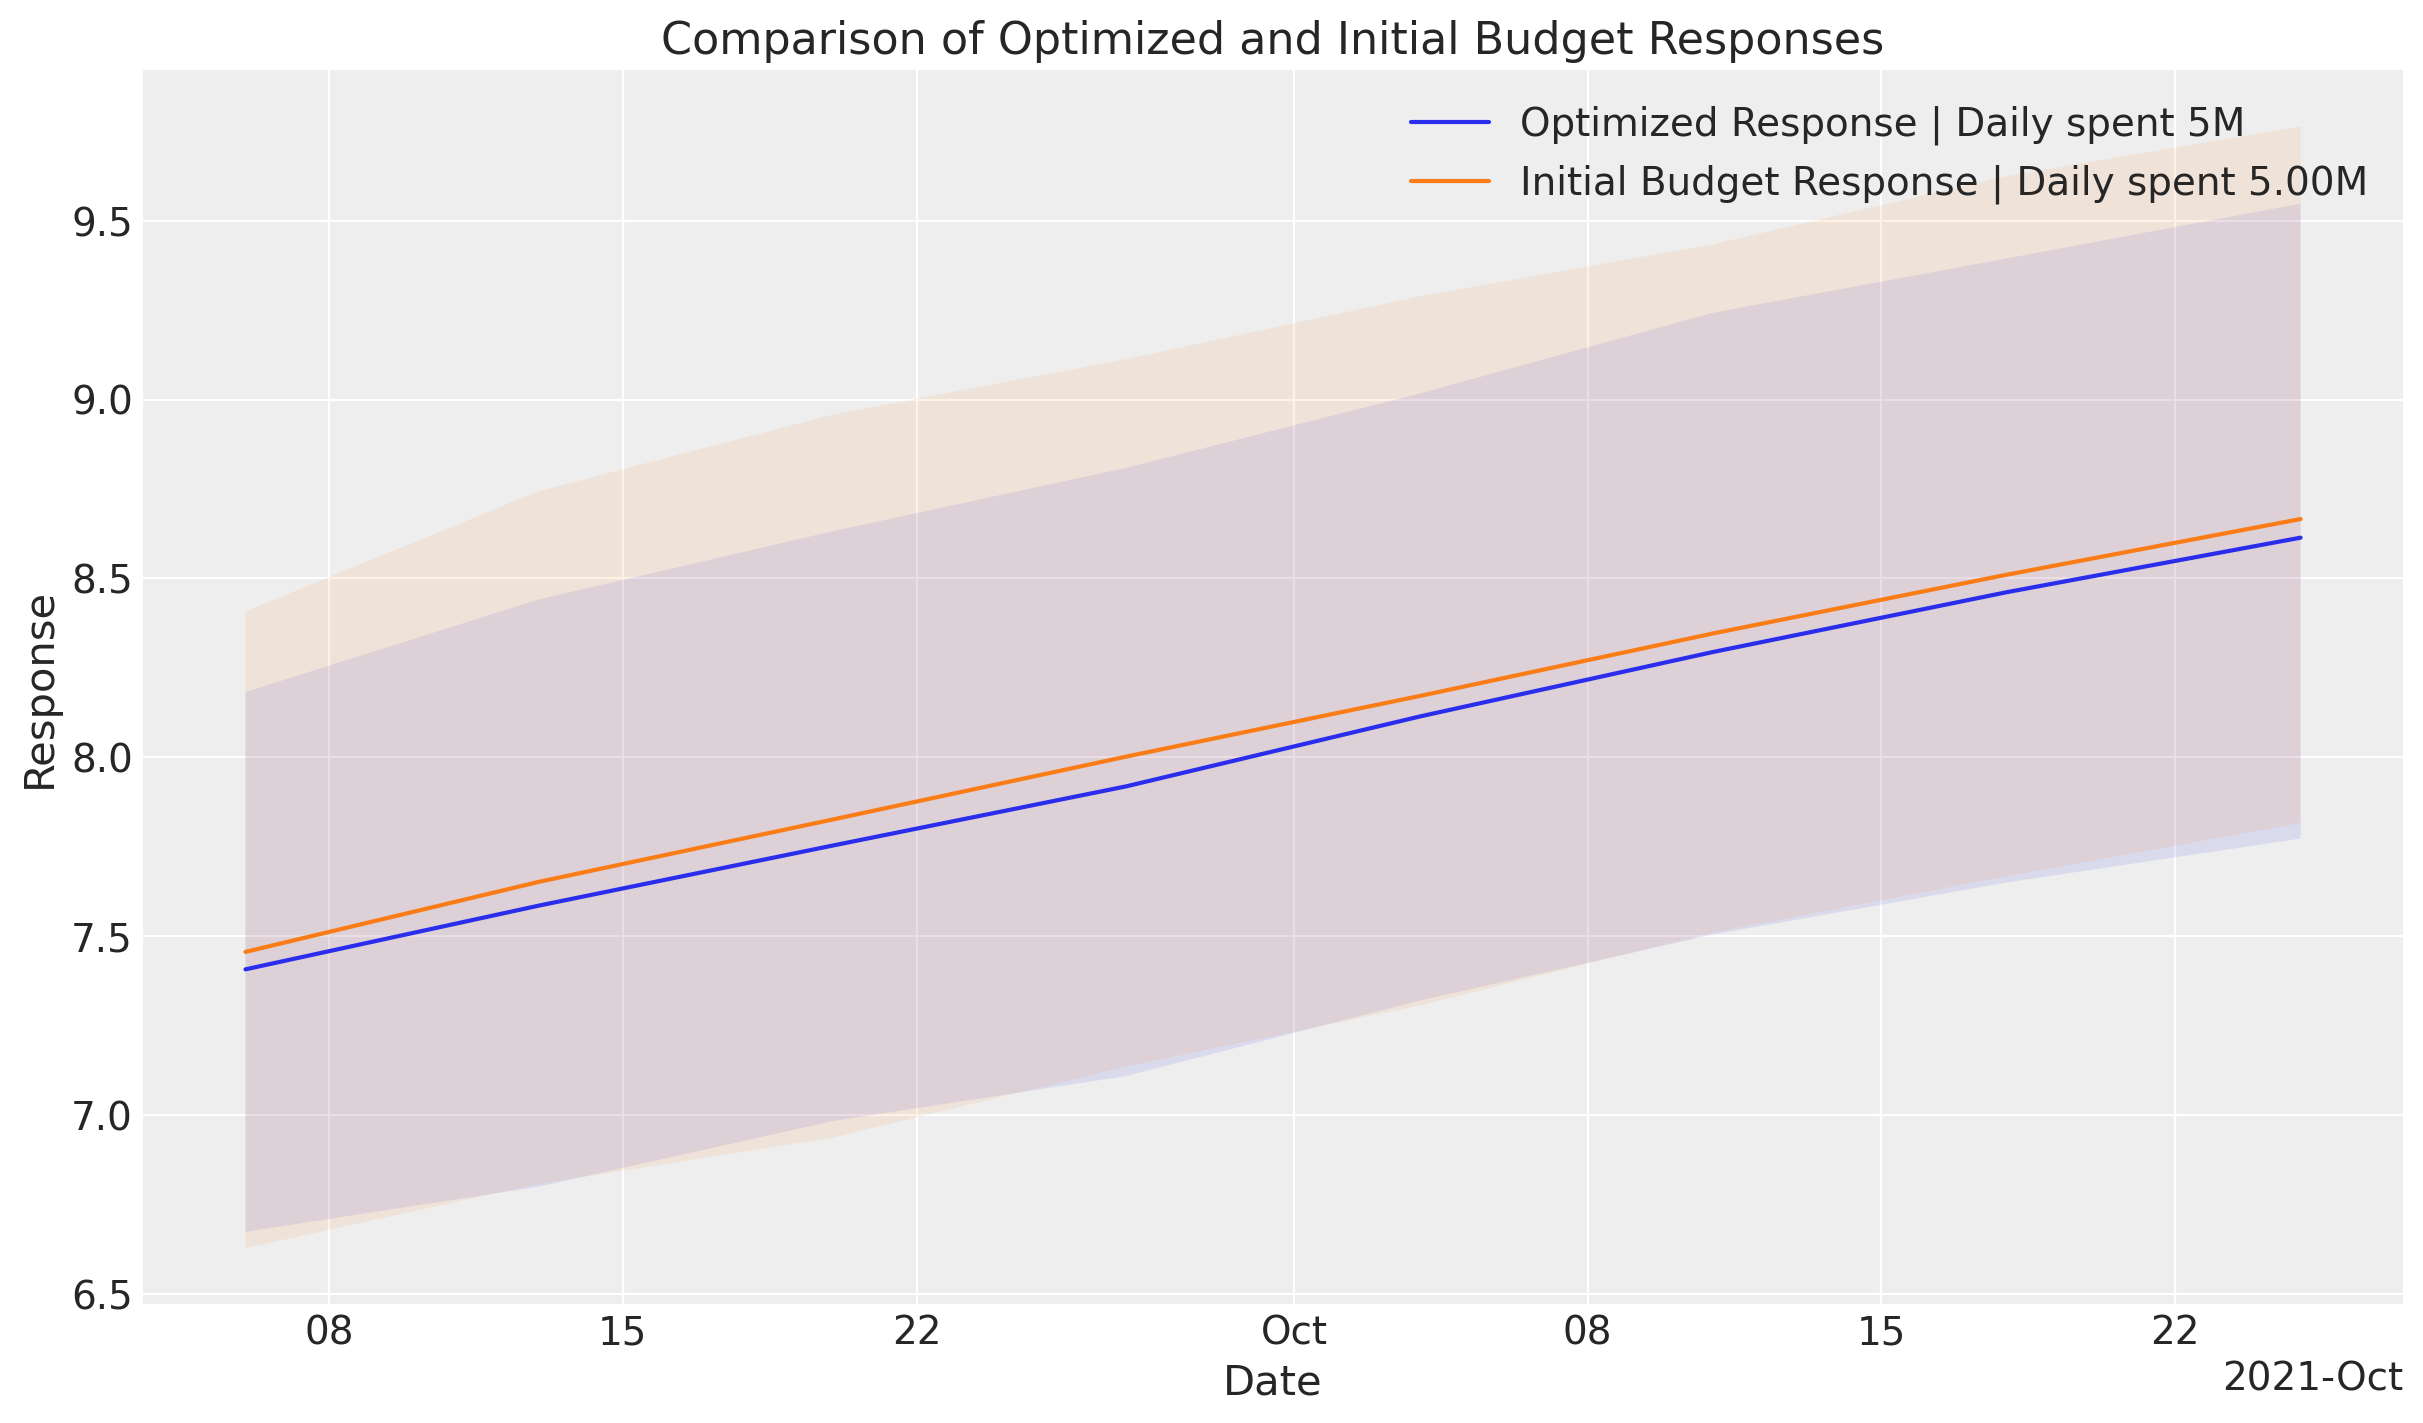

In [14]:
y_response_original_scale_optimize = response["y"] * mmm.get_target_transformer()["scaler"].scale_

# Plotting optimized response
y_response_original_scale_optimize.mean(dim="sample").plot(
    label=f'Optimized Response | Daily spent {sum(mmm.optimal_allocation_dict.values()):.0f}M'
)
plt.fill_between(
    x=y_response_original_scale_optimize.date.values,
    y1=y_response_original_scale_optimize.quantile(.025, dim="sample"),
    y2=y_response_original_scale_optimize.quantile(.95, dim="sample"),
    alpha=.1,
)

# Plotting initial budget response
response_initial_budget["y"].mean(dim="sample").plot(
    label='Initial Budget Response | Daily spent 5.00M'
)
plt.fill_between(
    x=response_initial_budget.y.date.values,
    y1=response_initial_budget.y.quantile(.025, dim="sample"),
    y2=response_initial_budget.y.quantile(.95, dim="sample"),
    alpha=.1,
)

# Adding labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Response')
plt.legend()
plt.title('Comparison of Optimized and Initial Budget Responses');

This information will allow you to compare the optimization results against what could have been your initial configuration and budget distribution. While our budget distribution changes, the contribution estimate remains almost the same for this budget. Could we be spending more than needed? Furthermore, how can we identify the optimal spent amount if this situation arises?

One approach to explore this could be to create various scenarios and observe how our estimated contribution fluctuates according to each scenario.

### Creating Budget Scenarios
Envision the subsequent situation: You're managing marketing operations for a rapidly growing retail company. The management team has allocated a considerable advertising budget and anticipates substantial results in the next quarter. However, given the uncertainty in economic trends, you are tasked with designing a budget allocation strategy capable of accommodating various scenarios.

Before the advent of a robust MMM model, your approach might have been simplistic yet naive: distribute the funds equally across the two primary channels, x1 and x2. This would result in a linear, evenly split distribution of 2.5 million euros each, given a total budget of 5 million euros.

Nevertheless, with the MMM model now at your disposal, you realize a more sophisticated approach is feasible. You're eager to investigate how this budget could be optimized across multiple scenarios:

1. Status Quo Scenario: What if the market stays stable? What is the best allocation?
2. Growth Scenario: What if the market suddenly becomes more favorable? How should the extra budget be allocated?
3. Recession Scenario: What if there is a market downturn and the budget gets cut by 40%?

Given that you are treading into uncertain waters, you set certain constraints. Each channel must have a minimum spending of 1 million euros, ensuring base-level visibility. The maximum cap is ±5 million euros (depending on your scenario), respecting the total budget.

In [15]:
# Initialize two variables to save the results and base conditions for each scenario.
scenarios_result = []
scenarios = np.array([0.6, 0.8, 1.2, 1.8])
for scenario in scenarios:
    tmp_response = mmm.allocate_budget_to_maximize_response(
        budget=total_budget * scenario,
        num_days=8,
        time_granularity="weekly",
        budget_bounds=budget_bounds
    )
    scenarios_result.append(tmp_response)

Sampling: [y]


Sampling: [y]


We now have two lists containing the expected results with and without model optimization. This will return the same plot as before but based on each of the scenarios.

In [ ]:
fig_main, ax_main = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(20, 5)
)
for i, scenario in enumerate(scenarios_result):
    _, ax = mmm.plot_budget_allocation(samples=scenario, ax=ax_main[i])
    ax.set_title(f'Budget Allocation for Scenario {scenarios[i]*total_budget:.0f}M')
plt.show()

The graph indicates that boosting the budget beyond an spend level greater than 3 Million induces extremely marginal changes in the potential outcome. Therefore, one can use the budget detailed in scenario three as a cap for our budget.

However, is this the best method to invest our resources? So far, we have considered general constraints for each channel. However, since our curve saturates and beyond a specific point, it does not significantly elevate its contribution. Wouldn't it be crucial to incorporate these limitations?

### Adding Business or Channel Constraints
There may be instances where, despite the recommendation to invest more in a particular channel than another, it may not be feasible.

Consider this: Given your current budget, you have already maxed out the number of people you can reach within a specific platform. Therefore, further spending will only increase the frequency without adding new reach. In this scenario, does it make sense to raise the budget? This is a classic example of budget limitations based on platform restrictions.

In such cases, a dictionary can be created with limits for each channel, and the optimization function can be reapplied.

In [ ]:
constrained_response = mmm.allocate_budget_to_maximize_response(
    budget=total_budget,
    num_days=8,
    time_granularity="weekly",
    budget_bounds={"x1": [0, 4], "x2": [0, 3]}
)

In [ ]:
fig, ax = mmm.plot_budget_allocation(samples=constrained_response, figsize=(12, 8))
fig.suptitle("Response vs spent per channel");

Utilizing bounds is crucial, as all saturation curves in PyMC-Marketing are asymptotic. Therefore, without a constraint on your factors, the optimizer will consistently seek to use 100% of the funds because it will always observe an increase within `y` (target).

If you have yet to notice, this is why, in the previous example, the optimizer always utilized the whole budget in all scenarios. However, should you provide these limits, the optimizer can verify whether it is necessary to use your entire budget.

Let us examine the subsequent plot closely!

In [ ]:
sigmoid_response_curve_fig = mmm.plot_direct_contribution_curves(
    show_fit=True,  xlim_max=3
)

Although in principle we assign a limit of 1.5 spending for each channel, we can observe that at least for x1 after spending more than 1.2, we enter the plateau effect of the curve where we get almost zero return in `y` for each unit extra of `x`.

Additionally, based on the information above, a **9M** budget or a **3M** budget did not represent a big change in contribution. So let's adjust the budget as well.

In [ ]:
limit_constrained_response = mmm.allocate_budget_to_maximize_response(
    budget=2,
    num_days=8,
    time_granularity="weekly",
    budget_bounds={"x1": [0, 1.2], "x2": [0, 1.5]}
)

In [ ]:
fig, ax = mmm.plot_budget_allocation(samples=limit_constrained_response, figsize=(12, 8))
fig.suptitle("Response vs spent per channel");

In [ ]:
y_response_original_scale_optimize = limit_constrained_response["y"] * mmm.get_target_transformer()["scaler"].scale_

# Plotting optimized response
y_response_original_scale_optimize.mean(dim="sample").plot(
    label=f'Optimized Response | Daily spent {sum(mmm.optimal_allocation_dict.values()):.2f}M'
)
plt.fill_between(
    x=y_response_original_scale_optimize.date.values,
    y1=y_response_original_scale_optimize.quantile(.025, dim="sample"),
    y2=y_response_original_scale_optimize.quantile(.95, dim="sample"),
    alpha=.1,
)

# Plotting initial budget response
response_initial_budget["y"].mean(dim="sample").plot(
    label=f'Initial Budget Response | Daily spent {5.00}M'
)
plt.fill_between(
    x=response_initial_budget.y.date.values,
    y1=response_initial_budget.y.quantile(.025, dim="sample"),
    y2=response_initial_budget.y.quantile(.95, dim="sample"),
    alpha=.1,
)

# Adding labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Response')
plt.legend()
plt.title('Comparison of Optimized and Initial Budget Responses');

The new result is much clearer. By using less than half of the budget with an optimal distribution, we could achieve the same outcomes as our initial setup, which distributed the budget evenly across all channels. On the other hand, the optimal allocation distributes the budget in levels known by the model, reducing the uncertainty around the estimated impact. This is because the initial allocation was at unprecedented levels of spend in the model, resulting in greater uncertainty.

By default, if you need more prior knowledge about the limits, we recommend using alpha (the plateau) as the limit for each channel.

## Benefits and Limitations
In marketing analytics, curve-fitted Media Mix Models (MMMs) provide enriching insights by simplifying intricate systems, facilitating optimization, aiding scenario planning, and delivering quantifiable metrics for strategy evaluation. Each of these advantages presents compelling reasons to incorporate such models. The optimization consider the delay effect overtime, meaning the optimization is generated across periods.

Nevertheless, it is pivotal to acknowledge that these models do possess their own set of limitations. The primary ones are the assumptions of time invariance and generalized behavior, signifying an incomplete comprehension of market dynamics. The no-impact variance assumptions are not specific to the curves, as the model does not account for these effects. Hence, curves should always be carefully considered.


## Other methods to explore
Even if the method is promising, use other optimization options which includes the full posterior could be a powerful and interesting solution as it's described on the following blog ["Using bayesian decision making to optimize supply chains"](https://twiecki.io/blog/2019/01/14/supply_chain/)

The current methodology is similar to the ones used on other libraries as [Robyn from Meta](https://facebookexperimental.github.io/Robyn/docs/features/#budget-allocation) and Google [Lightweight from Google](https://github.com/google/lightweight_mmm). You can explore the solutions and compare if needed.

## Conclusion
MMM models and methodologies used here are designed to bridge the gap between theoretical rigor and actionable marketing insights. They represent a significant stride towards a more data-driven, analytical approach to marketing budget allocation, which could change how organizations invest in customer acquisition and retention.

Although it is a promising tool, it is essential to highlight that this methodology and software release is still experimental. Like any emerging technology, it comes with inherent limitations and assumptions that users should be aware of. The models can offer actionable insights, but they should be cautiously used and in tandem with various forms of analysis. Context is crucial, and while models aim to encapsulate general trends, they might not account for all nuances.

Consequently, your engagements, feedback, and thoughts are not merely welcomed but actively solicited to make this tool as practical and universally applicable as possible.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor